3

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#reading files
def unpickle(file): #code from dataset page
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

batch=unpickle("data_batch_1")

X_train = batch[b"data"]
Y_train = batch[b"labels"]
print(X_train.shape)

batch=unpickle("test_batch")

X_test = batch[b"data"]
Y_test = batch[b"labels"]

for i in range(4):
    batch = unpickle("data_batch_"+ str(i+2))
    X_train = np.concatenate((X_train, batch[b"data"]))
    Y_train = np.concatenate((Y_train, batch[b"labels"]))
"""
X_train=[[255,255,255],[100,100,100],[0,0,0],[255,255,255],[100,100,100],[0,0,0],[255,255,255],[100,100,100],[0,0,0],[255,255,255],[100,100,100],[0,0,0],[255,255,255],[100,100,100],[0,0,0]]
Y_train=[0,1,2,0,1,2,0,1,2,0,1,2,0,1,2]
X_train=np.array(X_train)
Y_train=np.array(Y_train)
"""
print(X_train)
print(Y_train)

print(X_train.shape)
X_train = X_train.astype("float64")
X_train_norm = X_train / 255
X_test = X_test.astype("float64")
X_test_norm = X_test / 255
#print(X_train[9][9])

print(X_test.shape)

label_names=unpickle("batches.meta")
print(label_names[b"label_names"])

Y_test = pd.get_dummies(Y_test)
Y_train = pd.get_dummies(Y_train)
Y_train = Y_train.astype("float64")
Y_test = Y_test.astype("float64")
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
#Y_test.to_numpy

print(type(Y_train))
print(Y_test.shape)


(10000, 3072)
[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [ 35  40  42 ...  77  66  50]
 [189 186 185 ... 169 171 171]
 [229 236 234 ... 173 162 161]]
[6 9 9 ... 9 1 1]
(50000, 3072)
(10000, 3072)
[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']
<class 'numpy.ndarray'>
(10000, 10)


In [ ]:
#categorical cross entropy
#can't handle yh=0
def CCE(y,yh):
    N,D = y.shape
    output = np.zeros(D)
    for d in range(D):
        for n in range(N):
            output[d] += -1*y[n][d]*np.log(yh[n][d])
    return output#change to np.sum(output) for total loss?
#returns loss for each catergory

In [ ]:
def maxArray(a):
    i=0
    a0=np.zeros(a.shape)
    for k in a:
        if (k==np.max(a)):
            a0[i]=1
        else:
            a0[i]=0
        i+=1
    return a0

def percentAcc(y,yh):
    N,D = y.shape
    yh0=[]
    for i in range(N):
        yh0.append(maxArray(yh[i]))
    yh0=np.array(yh0)
    error=0
    for j in range(N):
        if (not np.array_equiv(yh0[j],y[j])):
            error+=1
    percentError = error/N
    accuracy = 1-percentError
    return accuracy

In [ ]:
def ReLU_act(x, der=False):
    
    if (der == True): # the derivative of the ReLU is the Heaviside Theta
        f = np.heaviside(x, 1)
    else :
        f = np.maximum(x, 0)
    
    return f

def htan_act(x, der=False):
   
    if (der == True): # the derivative of htan
        f = 1-(np.tanh(x))**2
    else :
        f = np.tanh(x)
    
    return f


def leakyReLU_act(x, der=False):
    
    if (der == True): # the derivative of leakyReLU
        f = np.where(x > 0, 1, 0.01)
    else :
        f = np.where(x > 0, x, x * 0.01)
    
    return f

In [ ]:
class GradientDescent:
    
    def __init__(self, learning_rate=.1, max_iters=1e4, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        
    def run(self, gradient_fn, x, y, params):
        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t < self.max_iters:
            grad = gradient_fn(x, y, params)
            print("t=",t)
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
                #print("params: ", params[p])
            t += 1
                
            norms = np.array([np.linalg.norm(g) for g in grad])
        return params


#L(y,yh) = -np.sum(y*log(yh))
import numpy as np
from scipy.special import softmax

np.random.seed(10)


ReLu = lambda x: np.max(0,x)

class MLP:

    def __init__(self, hidden_layers, activation, hidden_layers_size = [64,64]):
        self.activation = activation
        self.hidden_layers = hidden_layers
        self.num_of_layers = hidden_layers + 2
        self.hidden_layers_size = hidden_layers_size
        self.weights = []
        self.bias = []

    def fit(self, x, y, optimizer):
        N,D = x.shape
        Ny, Dy = y.shape
        
            #if no hidden layer
        if (self.hidden_layers == 0):
            u = np.random.randn(D,Dy) * .01
            params0 = [u]

            def gradient(x, y, params):
                N,D = x.shape
                u = params
                yh =  np.zeros((N, 10))
                yh1 = np.dot(x, u[0])
                for i in range(N):
                    yh[i] = softmax(yh1[i])#.reshape(10000, 10)#N
                #print(y.shape)
                #print(x.shape)
                #print(len(u))
                #print("yh",yh.shape)
                dy = np.subtract(yh,y) #N
                du = np.dot(x.T, dy)/N #M
                dparams = [du]
                return dparams

        elif (self.hidden_layers == 1):
            v = np.random.randn(D,self.hidden_layers_size[0]) * .01 #edge between x and (first)z
            w = np.random.randn(self.hidden_layers_size[0], Dy) * .01 #edge between (last)z and y
            params0 = [v,w]
            print(v)

            def gradient(x, y, params):
                N,D = x.shape
                v, w = params
                z = self.activation(np.dot(x, v)) #N x M
                yh =  np.zeros((N, 10))
                yh1 = np.dot(z, w)
                for i in range(N):
                    yh[i] = softmax(yh1[i])#N
                dy = yh - y #N
                dw = np.dot(z.T, dy)/N #M
                dz = np.dot(dy, w.T) #D x M
                dv = np.dot(x.T, dz * self.activation(z, der = True))/N
                dparams = [dv, dw]
                return dparams

        elif (self.hidden_layers == 2):
            v = np.random.randn(D,self.hidden_layers_size[0]) * .01 #edge between x and (first)z
            u = np.random.randn(self.hidden_layers_size[0], self.hidden_layers_size[1]) * .01
            w = np.random.randn(self.hidden_layers_size[1], Dy) * .01 #edge between (last)z and y
            params0 = [v,u,w]

            def gradient(x, y, params):
                N,D = x.shape
                v, u, w = params
                z1 = self.activation(np.dot(x, v)) #N x M
                z2 = self.activation(np.dot(z1, u)) #N x M
                yh =  np.zeros((N, 10))
                yh1 = np.dot(z2, w)
                for i in range(N):
                    yh[i] = softmax(yh1[i])#N
                dy = yh - y #N
                dw = np.dot(z2.T, dy)/N #M
                dz2 = np.dot(dy, w.T) #N x M
                du = np.dot(z1.T, dz2 * self.activation(z2, der = True))/N #D x M
                dz1 = np.dot(dz2, u.T) #N x M
                dv = np.dot(x.T, dz1 * self.activation(z1, der = True))/N #D x M
                dparams = [dv, du, dw]
                return dparams

        #print("hello")
        self.params = optimizer.run(gradient, x, y, params0)
        #print(self.params)
        return self

    def predict(self, x):
        if (self.hidden_layers == 0):
            u = self.params
            #print(u)
            #print(x)
            N, D = x.shape
            yh1 = np.dot(x,u[0])
            yh =  np.zeros((N, 10))
            for i in range(N):
                yh[i] = softmax(yh1[i])
            #print("yh",yh.shape)
            return yh
        elif (self.hidden_layers == 1):
            v, w = self.params
            z = self.activation(np.dot(x, v)) #N x M
            N, D = x.shape
            yh =  np.zeros((N, 10))
            for i in range(N):
                yh[i] = softmax(np.dot(z[i], w))#N
            #yh = np.dot(z, w)
            #yh=softmax(yh)
            return yh
        elif (self.hidden_layers == 2):
            v, u, w = self.params
            z1 = self.activation(np.dot(x, v)) #N x M
            z2 = self.activation(np.dot(z1, u))
            N, D = x.shape
            yh1 = np.dot(z2, w)#N
            yh =  np.zeros((N, 10))
            for i in range(N):
                yh[i] = softmax(yh1[i])
            return yh
        
    def evaluate_acc(self, y, yh):
            return percentAcc(y,yh)


"""
#1 hidden layer
model = MLP(0, htan_act,hidden_layers_size = [])
optimizer = GradientDescent(learning_rate=.1, max_iters=100)
fit1 = model.fit(X_train_norm, Y_train, optimizer)
"""


'\n#1 hidden layer\nmodel = MLP(0, htan_act,hidden_layers_size = [])\noptimizer = GradientDescent(learning_rate=.1, max_iters=100)\nfit1 = model.fit(X_train_norm, Y_train, optimizer)\n'

In [ ]:
#Task 3.1
#no hidden layers
import numpy as np


model = MLP(0, ReLU_act,hidden_layers_size = [])
optimizer = GradientDescent(learning_rate=.1, max_iters=250)
fit1 = model.fit(X_train_norm, Y_train, optimizer)

pred1 = fit1.predict(X_train_norm)
print(CCE(Y_train,pred1))
print(fit1.evaluate_acc(Y_train,pred1))

pred1 = fit1.predict(X_test_norm)
print(CCE(Y_test,pred1))
print(fit1.evaluate_acc(Y_test,pred1))

t= 1
t= 2
t= 3
t= 4
t= 5
t= 6
t= 7
t= 8
t= 9
t= 10
t= 11
t= 12
t= 13
t= 14
t= 15
t= 16
t= 17
t= 18
t= 19
t= 20
t= 21
t= 22
t= 23
t= 24
t= 25
t= 26
t= 27
t= 28
t= 29
t= 30
t= 31
t= 32
t= 33
t= 34
t= 35
t= 36
t= 37
t= 38
t= 39
t= 40
t= 41
t= 42
t= 43
t= 44
t= 45
t= 46
t= 47
t= 48
t= 49
t= 50
t= 51
t= 52
t= 53
t= 54
t= 55
t= 56
t= 57
t= 58
t= 59
t= 60
t= 61
t= 62
t= 63
t= 64
t= 65
t= 66
t= 67
t= 68
t= 69
t= 70
t= 71
t= 72
t= 73
t= 74
t= 75
t= 76
t= 77
t= 78
t= 79
t= 80
t= 81
t= 82
t= 83
t= 84
t= 85
t= 86
t= 87
t= 88
t= 89
t= 90
t= 91
t= 92
t= 93
t= 94
t= 95
t= 96
t= 97
t= 98
t= 99
t= 100
t= 101
t= 102
t= 103
t= 104
t= 105
t= 106
t= 107
t= 108
t= 109
t= 110
t= 111
t= 112
t= 113
t= 114
t= 115
t= 116
t= 117
t= 118
t= 119
t= 120
t= 121
t= 122
t= 123
t= 124
t= 125
t= 126
t= 127
t= 128
t= 129
t= 130
t= 131
t= 132
t= 133
t= 134
t= 135
t= 136
t= 137
t= 138
t= 139
t= 140
t= 141
t= 142
t= 143
t= 144
t= 145
t= 146
t= 147
t= 148
t= 149
t= 150
t= 151
t= 152
t= 153
t= 154
t= 155
t= 156
t= 157
t= 158
t=

In [0]:
#Task 3.1
#1 hidden layers
model = MLP(1, ReLU_act,hidden_layers_size = [256])
optimizer = GradientDescent(learning_rate=.01, max_iters=250)
fit1 = model.fit(X_train_norm, Y_train, optimizer)

pred1 = fit1.predict(X_train_norm)
print(CCE(Y_train,pred1))
print(fit1.evaluate_acc(Y_train,pred1))

pred1 = fit1.predict(X_test_norm)
print(CCE(Y_test,pred1))
print(fit1.evaluate_acc(Y_test,pred1))

In [ ]:
#Task 3.1
#2 hidden layers

model = MLP(2, ReLU_act,hidden_layers_size = [256,256])
optimizer = GradientDescent(learning_rate=.1, max_iters=250, keep_history = True)
fit1 = model.fit(X_train_norm, Y_train, optimizer)

#pred1 = fit1.predict(X_train_norm)
#print(CCE(Y_train,pred1))
#print(fit1.evaluate_acc(Y_train,pred1))

pred1 = fit1.predict(X_test_norm)
print(CCE(Y_test,pred1))
print(fit1.evaluate_acc(Y_test,pred1))

import matplotlib.pyplot as plt

# Get the training history from the model
train_loss_history = []
train_acc_history = []
if fit1.params_history is not None:
    for params in fit1.params_history:
        yh = model.predict(X_train_norm)
        train_loss_history.append(CCE(Y_train, yh))
        train_acc_history.append(model.evaluate_acc(Y_train, yh))

# Plot the training loss and accuracy over time
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(train_loss_history)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Training Loss')
ax[1].plot(train_acc_history)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Training Accuracy')
plt.show()

# Get the testing accuracy
yh = model.predict(X_test_norm)
test_acc = model.evaluate_acc(Y_test, yh)
print(f'Testing Accuracy: {test_acc}')


t= 1
/tmp/ipykernel_76/946162066.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  params1 = np.array(params)
t= 2
t= 3
t= 4
t= 5


KeyboardInterrupt: 

In [0]:
#Task 3.2
#tanh
model = MLP(2, htan_act,hidden_layers_size = [256,256])
optimizer = GradientDescent(learning_rate=.1, max_iters=250)
fit1 = model.fit(X_train_norm, Y_train, optimizer)

pred1 = fit1.predict(X_train_norm)
print(CCE(Y_train,pred1))
print(fit1.evaluate_acc(Y_train,pred1))

pred1 = fit1.predict(X_test_norm)
print(CCE(Y_test,pred1))
print(fit1.evaluate_acc(Y_test,pred1))

In [0]:
#Task 3.2
#leaky
model = MLP(2, leakyReLU_act,hidden_layers_size = [256,256])
optimizer = GradientDescent(learning_rate=.1, max_iters=250)
fit1 = model.fit(X_train_norm, Y_train, optimizer)

pred1 = fit1.predict(X_train_norm)
print(CCE(Y_train,pred1))
print(fit1.evaluate_acc(Y_train,pred1))

pred1 = fit1.predict(X_test_norm)
print(CCE(Y_test,pred1))
print(fit1.evaluate_acc(Y_test,pred1))

In [0]:
#task 3.3 (extra)
#label smoothing
def smoothing(y,eps):
    N, D = y.shape
    ysmooth = np.zeros(y.shape)
    for n in range(N):
        for d in range(D):
            if (y[n][d] == 0):
                ysmooth[n][d] = eps/3
            elif (y[n][d] == 1):
                ysmooth[n][d] = 1-eps
    return ysmooth

Y_train_smooth = smoothing(Y_train,0.001)

model = MLP(2, ReLU_act,hidden_layers_size = [256,256])
optimizer = GradientDescent(learning_rate=.1, max_iters=250)
fit1 = model.fit(X_train_norm, Y_train_smooth, optimizer)

pred1 = fit1.predict(X_test_norm)
print(CCE(Y_test,pred1))
print(fit1.evaluate_acc(Y_test,pred1))

In [0]:
#task 3.3
#L2
class GradientDescentL2:
    
    def __init__(self, learning_rate=.1, max_iters=1e4, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        
    def run(self, gradient_fn, x, y, params, lam):
        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t < self.max_iters:
            grad = gradient_fn(x, y, params)
            print("t=",t)
            for p in range(len(params)):
                params[p] = params[p] - self.learning_rate * grad[p] - self.learning_rate*lam*params[p]/len(params)
                #print("params: ", params[p])
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        return params


#L(y,yh) = -np.sum(y*log(yh))
import numpy as np
from scipy.special import softmax
ReLu = lambda x: np.max(0,x)

class MLPL2:

    def __init__(self, hidden_layers, activation, hidden_layers_size = [64,64],lam=0.1):
        self.activation = activation
        self.hidden_layers = hidden_layers
        self.num_of_layers = hidden_layers + 2
        self.hidden_layers_size = hidden_layers_size
        self.weights = []
        self.bias = []
        self.lam=lam

    def fit(self, x, y, optimizer):
        N,D = x.shape
        Ny, Dy = y.shape

        if (self.hidden_layers == 2):
            v = np.random.randn(D,self.hidden_layers_size[0]) * .01 #edge between x and (first)z
            u = np.random.randn(self.hidden_layers_size[0], self.hidden_layers_size[1]) * .01
            w = np.random.randn(self.hidden_layers_size[1], Dy) * .01 #edge between (last)z and y
            params0 = [v,u,w]

            def gradient(x, y, params):
                N,D = x.shape
                v, u, w = params
                z1 = self.activation(np.dot(x, v)) #N x M
                z2 = self.activation(np.dot(z1, u)) #N x M
                yh =  np.zeros((N, 10))
                yh1 = np.dot(z2, w)
                for i in range(N):
                    yh[i] = softmax(yh1[i])#N
                dy = yh - y #N
                dw = np.dot(z2.T, dy)/N #M
                dz2 = np.dot(dy, w.T) #N x M
                du = np.dot(z1.T, dz2 * self.activation(z2, der = True))/N #D x M
                dz1 = np.dot(dz2, u.T) #N x M
                dv = np.dot(x.T, dz1 * self.activation(z1, der = True))/N #D x M
                dparams = [dv, du, dw]
                return dparams

        #print("hello")
        self.params = optimizer.run(gradient, x, y, params0, self.lam)
        #print(self.params)
        return self

    def predict(self, x):
        if (self.hidden_layers == 2):
            v, u, w = self.params
            z1 = self.activation(np.dot(x, v)) #N x M
            z2 = self.activation(np.dot(z1, u))
            N, D = x.shape
            yh1 = np.dot(z2, w)#N
            yh =  np.zeros((N, 10))
            for i in range(N):
                yh[i] = softmax(yh1[i])
            return yh
        
    def evaluate_acc(self, y, yh):
            return percentAcc(y,yh)


#2 hidden layer
model = MLPL2(2, htan_act,hidden_layers_size = [256,256],lam=0.1)
optimizer = GradientDescentL2(learning_rate=.1, max_iters=250)
fit1 = model.fit(X_train_norm, Y_train, optimizer)

pred1 = fit1.predict(X_test_norm)
print(fit1.evaluate_acc(Y_test,pred1))


In [0]:
#task 3.3
#L1
class GradientDescentL1:
    
    def __init__(self, learning_rate=.1, max_iters=1e4, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        
    def run(self, gradient_fn, x, y, params, lam):
        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t < self.max_iters:
            grad = gradient_fn(x, y, params)
            print("t=",t)
            for p in range(len(params)):
                params[p] = params[p] - self.learning_rate * grad[p] - self.learning_rate*lam*grad[p]/len(grad[p])
                #print("params: ", params[p])
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        return params


#L(y,yh) = -np.sum(y*log(yh))
import numpy as np
from scipy.special import softmax
ReLu = lambda x: np.max(0,x)

class MLPL1:

    def __init__(self, hidden_layers, activation, hidden_layers_size = [64,64],lam=0.1):
        self.activation = activation
        self.hidden_layers = hidden_layers
        self.num_of_layers = hidden_layers + 2
        self.hidden_layers_size = hidden_layers_size
        self.weights = []
        self.bias = []
        self.lam=lam

    def fit(self, x, y, optimizer):
        N,D = x.shape
        Ny, Dy = y.shape

        if (self.hidden_layers == 2):
            v = np.random.randn(D,self.hidden_layers_size[0]) * .01 #edge between x and (first)z
            u = np.random.randn(self.hidden_layers_size[0], self.hidden_layers_size[1]) * .01
            w = np.random.randn(self.hidden_layers_size[1], Dy) * .01 #edge between (last)z and y
            params0 = [v,u,w]

            def gradient(x, y, params):
                N,D = x.shape
                v, u, w = params
                z1 = self.activation(np.dot(x, v)) #N x M
                z2 = self.activation(np.dot(z1, u)) #N x M
                yh =  np.zeros((N, 10))
                yh1 = np.dot(z2, w)
                for i in range(N):
                    yh[i] = softmax(yh1[i])#N
                dy = yh - y #N
                dw = np.dot(z2.T, dy)/N #M
                dz2 = np.dot(dy, w.T) #N x M
                du = np.dot(z1.T, dz2 * self.activation(z2, der = True))/N #D x M
                dz1 = np.dot(dz2, u.T) #N x M
                dv = np.dot(x.T, dz1 * self.activation(z1, der = True))/N #D x M
                dparams = [dv, du, dw]
                return dparams

        #print("hello")
        self.params = optimizer.run(gradient, x, y, params0, self.lam)
        #print(self.params)
        return self

    def predict(self, x):
        if (self.hidden_layers == 2):
            v, u, w = self.params
            z1 = self.activation(np.dot(x, v)) #N x M
            z2 = self.activation(np.dot(z1, u))
            N, D = x.shape
            yh1 = np.dot(z2, w)#N
            yh =  np.zeros((N, 10))
            for i in range(N):
                yh[i] = softmax(yh1[i])
            return yh
        
    def evaluate_acc(self, y, yh):
            return percentAcc(y,yh)


#2 hidden layer
model = MLPL1(2, htan_act,hidden_layers_size = [256,256],lam=0.1)
optimizer = GradientDescentL1(learning_rate=.1, max_iters=250)
fit1 = model.fit(X_train_norm, Y_train, optimizer)

pred1 = fit1.predict(X_test_norm)
print(fit1.evaluate_acc(Y_test,pred1))


In [0]:
#Task 3.4
#non-normalized
model = MLP(2, ReLU_act,hidden_layers_size = [256,256])
optimizer = GradientDescent(learning_rate=.001, max_iters=250)
fit1 = model.fit(X_train, Y_train, optimizer)

pred1 = fit1.predict(X_train)
print(CCE(Y_train,pred1))
print(fit1.evaluate_acc(Y_train,pred1))

pred1 = fit1.predict(X_test)
print(CCE(Y_test,pred1))
print(fit1.evaluate_acc(Y_test,pred1))

t= 1
t= 2
t= 3
t= 4
t= 5
t= 6
t= 7
t= 8
t= 9
t= 1
t= 2
t= 3
t= 4
t= 5
t= 6
t= 7
t= 8
t= 9
t= 10
t= 11
t= 12
t= 13
t= 14
t= 15
t= 16
t= 17
t= 18
t= 19
t= 1
t= 2
t= 3
t= 4
t= 5
t= 6
t= 7
t= 8
t= 9
t= 10
t= 11
t= 12
t= 13
t= 14
t= 15
t= 16
t= 17
t= 18
t= 19
t= 20
t= 21
t= 22
t= 23
t= 24
t= 25
t= 26
t= 27
t= 28
t= 29
t= 1
t= 2
t= 3
t= 4
t= 5
t= 6
t= 7
t= 8
t= 9
t= 10
t= 11
t= 12
t= 13
t= 14
t= 15
t= 16
t= 17
t= 18
t= 19
t= 20
t= 21
t= 22
t= 23
t= 24
t= 25
t= 26
t= 27
t= 28
t= 29
t= 30
t= 31
t= 32
t= 33
t= 34
t= 35
t= 36
t= 37
t= 38
t= 39
t= 1
t= 2
t= 3
t= 4
t= 5
t= 6
t= 7
t= 8
t= 9
t= 10
t= 11
t= 12
t= 13
t= 14
t= 15
t= 16
t= 17
t= 18
t= 19
t= 20
t= 21
t= 22
t= 23
t= 24
t= 25
t= 26
t= 27
t= 28
t= 29
t= 30
t= 31
t= 32
t= 33
t= 34
t= 35
t= 36
t= 37
t= 38
t= 39
t= 40
t= 41
t= 42
t= 43
t= 44
t= 45
t= 46
t= 47
t= 48
t= 49


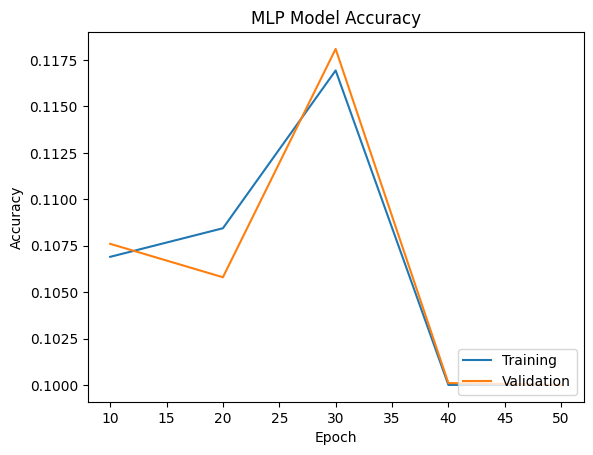

<Figure size 640x480 with 0 Axes>

In [ ]:
I=5
acc_train = np.zeros(I)
acc_test = np.zeros(I)
epochs = np.zeros(I)
for i in range(I):
    j=i+1
    J=j*10
    epochs[i]=J
    model = MLP(2, ReLU_act,hidden_layers_size = [256,256])
    optimizer = GradientDescent(learning_rate=.1, max_iters=J)
    fit1 = model.fit(X_train_norm, Y_train, optimizer)
    pred1 = fit1.predict(X_test_norm)
    acc_test[i] = fit1.evaluate_acc(Y_test,pred1)
    pred2 = fit1.predict(X_train_norm)
    acc_train[i] = fit1.evaluate_acc(Y_train,pred2)

plt.plot(epochs, acc_train, label="Train")
plt.plot(epochs, acc_test, label="Test")
plt.title('MLP Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()
plt.savefig("figX.png")


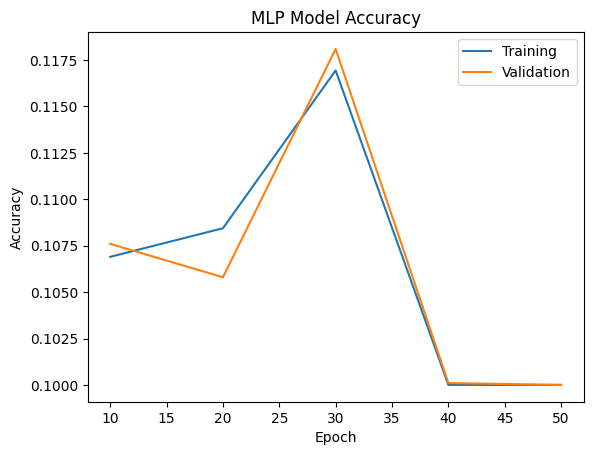

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(epochs, acc_train, label="Train")
plt.plot(epochs, acc_test, label="Test")
plt.title('MLP Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()
plt.savefig("figX.png")

In [ ]:
for j in range(5):
    v, u, w = fit1.params_history[j]
    print(fit1.params_history[j])
    z1 = fit1.activation(np.dot(X_train_norm, v)) #N x M
    z2 = fit1.activation(np.dot(z1, u))
    N, D = X_train_norm.shape
    yh1 = np.dot(z2, w)#N
    yh =  np.zeros((N, 10))
    for i in range(N):
        yh[i] = softmax(yh1[i])
    print(CCE(Y_train, yh))
pred1 = fit1.predict(X_train_norm)
print(CCE(Y_train,pred1))
print(fit1.evaluate_acc(Y_train,pred1))

[array([[ 0.00359862, -0.00622337,  0.00517044, ..., -0.01149266,
          0.00978587, -0.01432011],
        [-0.01094345,  0.00592067, -0.00135609, ...,  0.00817886,
         -0.00656732, -0.01851198],
        [-0.00352345,  0.00576355, -0.00835722, ..., -0.00663118,
          0.00021628,  0.00247054],
        ...,
        [ 0.01040238, -0.00145834,  0.01315549, ..., -0.00875944,
          0.02180796,  0.00631107],
        [-0.01135495,  0.0148511 , -0.01049163, ...,  0.00191742,
          0.00351671,  0.00148165],
        [ 0.00473514, -0.00377368, -0.00817229, ..., -0.00131995,
         -0.01574019,  0.00055757]])
 array([[ 1.10415510e-02,  3.05221797e-03,  2.59397909e-02, ...,
          8.99039578e-03,  5.10028356e-03,  2.96803760e-03],
        [ 1.22134968e-02, -4.81401179e-03,  5.65543453e-03, ...,
         -1.74665518e-02, -5.49187053e-03,  9.32755061e-03],
        [-6.27033012e-03, -3.44805773e-03,  4.15857433e-03, ...,
          7.35044270e-03, -2.97452588e-02,  1.66567407e-0

In [0]:
#Task 3.5 and 3.7
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Preprocess the data
X_train = X_train.astype('float64') / 255
X_test = X_test.astype('float64') / 255
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Create a CNN with 2 convolutional and 2 fully connected layers
# Conv2D layer with 32 filters, a 3x3 kernel size, and ReLU activation.
# MaxPooling2D layer with a 2x2 pool size.
# Conv2D layer with 64 filters, a 3x3 kernel size, and ReLU activation.
# MaxPooling2D layer with a 2x2 pool size.
# Flatten layer to flatten the output of the previous layer.
# Two fully connected Dense layers with 256 units and ReLU activation.
# A final Dense layer with 10 units and softmax activation, which gives us the probabilities of each class.
model = tf.keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(units=256, activation='relu'),
    layers.Dense(units=256, activation='relu'),
    layers.Dense(units=10, activation='softmax')
])

# Compile the model
# Compile the model with SGD optimizer
# Compile the model with SGD optimizer
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN on the CIFAR-10 dataset
history = model.fit(X_train, y_train, batch_size=128, epochs=1000, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)

# The validation accuracy
print('Test accuracy:', test_acc)

# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Pre-trained Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Pre-trained Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


In [0]:
#Task 3.6

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt

# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Preprocess the data
X_train = X_train.astype('float64') / 255
X_test = X_test.astype('float64') / 255
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Load a pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze all the convolutional layers
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer.trainable = False

# Add fully connected layers
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train only the fully connected layers
history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Pre-trained ResNet50 Fine-tuned Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pre-trained ResNet50 Fine-tuned Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9f1e1cdd-36c5-4e3a-8bd6-d469a42e5e8f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>